In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import us
import plotly.express as px
import mplcursors
import matplotlib as mpl
from pyspark.sql import SparkSession
import findspark
from pyspark.sql import functions as F
import seaborn as sns
from pyspark.sql.functions import mean



In [2]:

findspark.init()
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("sparkFunctions").getOrCreate()
from pyspark import SparkFiles
csv_file_paths = [
    "Resources/CurrentPopulationSurvey_1981.csv",
    "Resources/CurrentPopulationSurvey_1990.csv",
    "Resources/CurrentPopulationSurvey_1999.csv",
    "Resources/CurrentPopulationSurvey_2007.csv",
    "Resources/CurrentPopulationSurvey_2009.csv",
    "Resources/CurrentPopulationSurvey_2011.csv",
    "Resources/CurrentPopulationSurvey_2013.csv"
]
# Read each CSV file into a DataFrame and store them in a list
dfs = [spark.read.csv(path, sep=",", header=True, ignoreLeadingWhiteSpace=True) for path in csv_file_paths]

# Combine all DataFrames into a single DataFrame using union
combined_df = dfs[0]  # Start with the first DataFrame
for df in dfs[1:]:  # Iterate through the rest of the DataFrames
    combined_df = combined_df.union(df)

# Show the combined DataFrame
combined_df.show()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/08 11:39:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----+--------------------+---------+---+-----+----+--------+--------------------+----------+------+---+---+--------+--------+-------+
|year|          state name| region_1|age|sex_1|race|  race_1|      martial status|union type|educ99|occ|ind|wkswork1|uhrswork|incwage|
+----+--------------------+---------+---+-----+----+--------+--------------------+----------+------+---+---+--------+--------+-------+
|1981|            Virginia|    South| 38| male|   4|   Other|Married, spouse p...|      NULL|  NULL|245|798|      52|      40|17000.0|
|1981|             Vermont|Northeast| 58| male|   1|   White|Married, spouse p...|      NULL|  NULL|470|339|      52|      48|19000.0|
|1981|                Utah|     West| 35| male|   1|   White|Married, spouse p...|      NULL|  NULL|715|417|      52|      43|21000.0|
|1981|            Illinois|  Midwest| 33| male|   1|   White|            Divorced|      NULL|  NULL|485|857|      52|      60|19740.0|
|1981|District of Columbia|    South| 45| male|   2|   

In [3]:
combined_df.printSchema()


root
 |-- year: string (nullable = true)
 |-- state name: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex_1: string (nullable = true)
 |-- race: string (nullable = true)
 |-- race_1: string (nullable = true)
 |-- martial status: string (nullable = true)
 |-- union type: string (nullable = true)
 |-- educ99: string (nullable = true)
 |-- occ: string (nullable = true)
 |-- ind: string (nullable = true)
 |-- wkswork1: string (nullable = true)
 |-- uhrswork: string (nullable = true)
 |-- incwage: string (nullable = true)



In [4]:
# Group by 'industry' and 'sex_1', then calculate the mean income
grouped_data = combined_df.groupBy(['ind', 'sex_1']).agg(F.mean('incwage').alias('average_income'))

# Pivot to create a wide-format DataFrame
industries = grouped_data.groupBy('ind').pivot('sex_1').agg(F.first('average_income'))

# Show the final output
industries.show()



+----+------------------+------------------+
| ind|            female|              male|
+----+------------------+------------------+
| 467|          12962.54|23124.873646209388|
| 829|           8890.48|         38091.875|
| 691|          20293.75|35968.230769230766|
|1090|35828.368055555555| 47134.19626168224|
| 800|24745.752808988764| 42802.96923076923|
| 451|54423.444444444445|           50588.0|
| 870|17812.933333333334|24772.436619718308|
|1280| 33015.17931034483| 49668.95283018868|
|1870| 45412.27272727273| 63169.59581881533|
| 447| 13097.41935483871| 20136.73846153846|
| 591| 15051.69366197183| 27778.49393939394|
|6380| 35951.43265306122| 53481.00378310215|
| 718|10491.079166666666| 17397.55744680851|
| 307| 7942.333333333333| 16842.91304347826|
| 747| 8633.583333333334|11055.134328358208|
| 740|26041.570652173912| 33859.08888888889|
| 581|          12960.22| 26189.98305084746|
|1880|30850.708333333332| 49466.08928571428|
|4690|         26966.576| 38917.16312056738|
|8680|1943

24/10/08 11:39:24 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


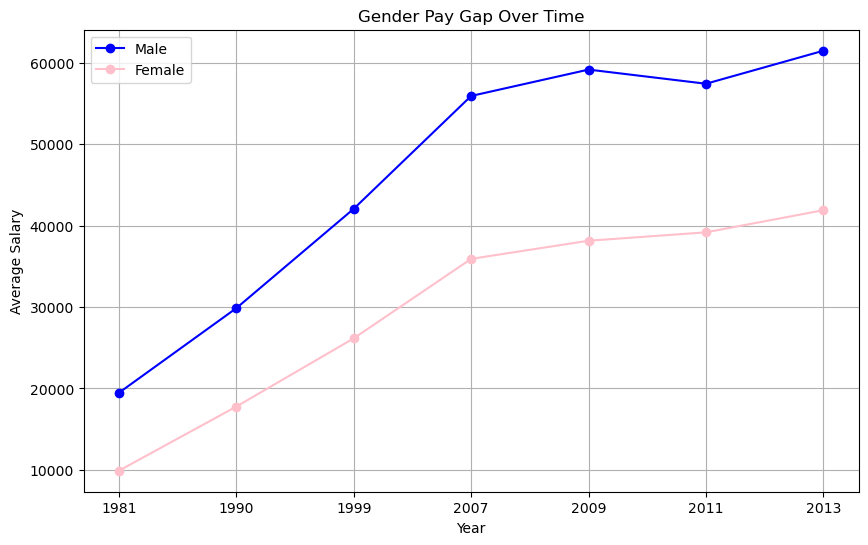

In [5]:
male_data = combined_df[combined_df['sex_1'] == 'male']
female_data = combined_df[combined_df['sex_1'] == 'female']

# First, calculate average salary for males and females grouped by year
avg_salary_male_year = male_data.groupBy('year').agg({'incwage': 'mean'}).withColumnRenamed('avg(incwage)', 'avg_salary')
avg_salary_female_year = female_data.groupBy('year').agg({'incwage': 'mean'}).withColumnRenamed('avg(incwage)', 'avg_salary')

# Convert the results to Pandas DataFrames for plotting
avg_salary_male_year_pd = avg_salary_male_year.toPandas()
avg_salary_female_year_pd = avg_salary_female_year.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(avg_salary_male_year_pd['year'], avg_salary_male_year_pd['avg_salary'], label='Male', color='blue', marker='o')
plt.plot(avg_salary_female_year_pd['year'], avg_salary_female_year_pd['avg_salary'], label='Female', color='pink', marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('Gender Pay Gap Over Time')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


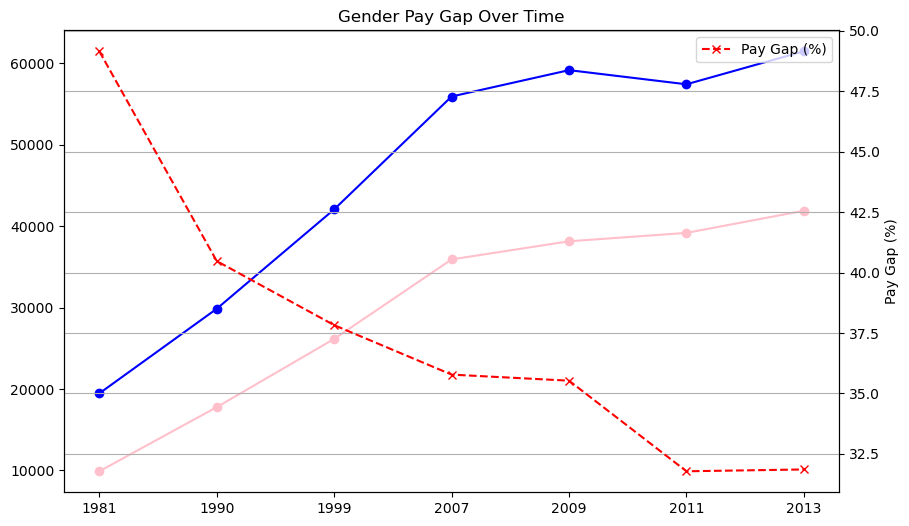

In [6]:
# Merge the male and female salary dataframes on the 'year' column
merged_df = avg_salary_male_year_pd.merge(avg_salary_female_year_pd, on='year', suffixes=('_male', '_female'))

# Calculate the percentage pay gap
merged_df['pay_gap_percentage'] = ((merged_df['avg_salary_male'] - merged_df['avg_salary_female']) / merged_df['avg_salary_male']) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Plot the average salary for males and females
plt.plot(merged_df['year'], merged_df['avg_salary_male'], label='Male Avg Salary', color='blue', marker='o')
plt.plot(merged_df['year'], merged_df['avg_salary_female'], label='Female Avg Salary', color='pink', marker='o')

# Add secondary y-axis for the pay gap percentage
ax2 = plt.gca().twinx()  # Create a secondary axis
ax2.plot(merged_df['year'], merged_df['pay_gap_percentage'], label='Pay Gap (%)', color='red', marker='x', linestyle='--')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Salary')
ax2.set_ylabel('Pay Gap (%)')
plt.title('Gender Pay Gap Over Time')

# Add legends for both plots
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot with grid
plt.grid(True)
plt.show()


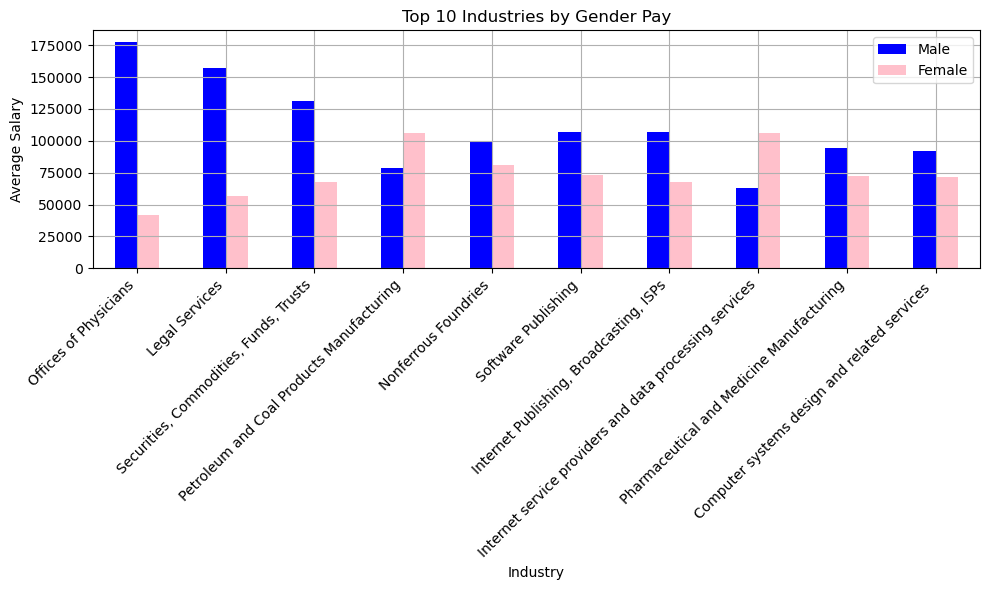

In [24]:
# Define the mapping of industry codes to descriptive names
industry_mapping = {
    '7970': 'Offices of Physicians',
    '7270': 'Legal Services',
    '6970': 'Securities, Commodities, Funds, Trusts',
    '6870': 'Banking and Related Activities',
    '3360': 'Nonferrous Foundries',
    '6490': 'Software Publishing',
    '6672': 'Internet Publishing, Broadcasting, ISPs',
    '2190': 'Pharmaceutical and Medicine Manufacturing',
    '480': 'Petroleum and Coal Products Manufacturing'
}

# Create a new column with descriptive names using `F.when()` to map the codes
combined_df = combined_df.withColumn('ind_name', 
    F.when(F.col('ind') == '7970', 'Offices of Physicians')
    .when(F.col('ind') == '7270', 'Legal Services')
    .when(F.col('ind') == '6970', 'Securities, Commodities, Funds, Trusts')
    .when(F.col('ind') == '6870', 'Banking and Related Activities')
    .when(F.col('ind') == '3360', 'Nonferrous Foundries')
    .when(F.col('ind') == '6490', 'Software Publishing')
    .when(F.col('ind') == '6672', 'Internet Publishing, Broadcasting, ISPs')
    .when(F.col('ind') == '2190', 'Pharmaceutical and Medicine Manufacturing')
    .when(F.col('ind') == '480', 'Petroleum and Coal Products Manufacturing')
    .when(F.col('ind') == '6692', 'Internet service providers and data processing services')
    .when(F.col('ind') == '7380', 'Computer systems design and related services ' )   
    .otherwise(F.col('ind')))

industries = combined_df.groupBy(['ind_name', 'sex_1']).agg(F.mean('incwage').alias('avg_salary'))
industries_pivoted = industries.groupBy('ind_name').pivot('sex_1').agg(F.first('avg_salary')).na.fill(0)
industries_pivoted = industries_pivoted.withColumn('total_salary', industries_pivoted['male'] + industries_pivoted['female'])
top_10_industries = industries_pivoted.orderBy('total_salary', ascending=False).limit(10)
top_10_industries_pd = top_10_industries.toPandas()

# Plot
top_10_industries_pd.set_index('ind_name')[['male', 'female']].plot(kind='bar', stacked=False, figsize=(10, 6), color=['blue', 'pink'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Industries by Gender Pay')
plt.xlabel('Industry')
plt.ylabel('Average Salary')
plt.legend(['Male', 'Female'], loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


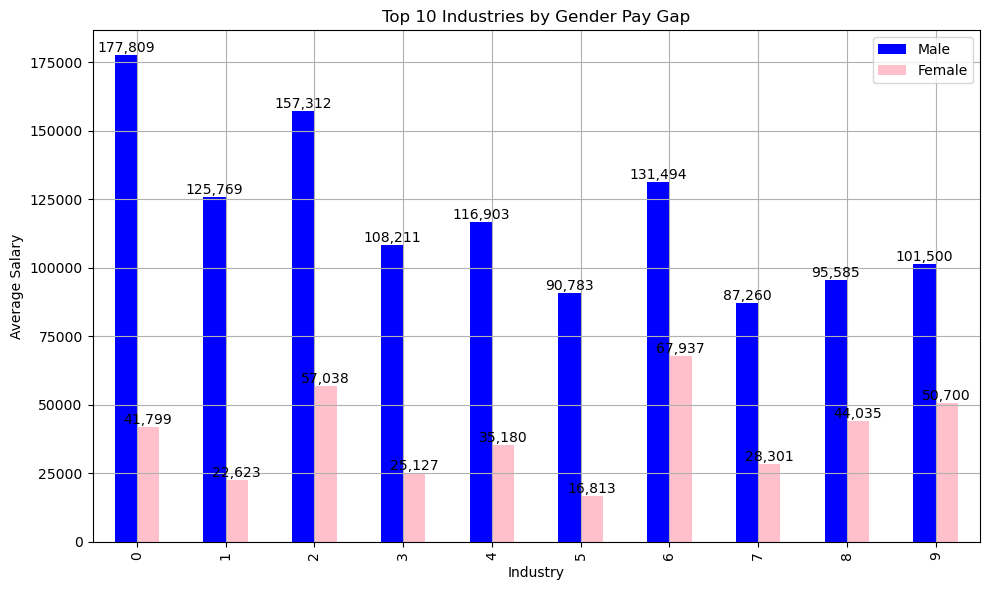

In [8]:
# Group data by industry and gender, and calculate the mean income wage
industries = (combined_df
              .groupBy('ind', 'sex_1')
              .agg(F.mean('incwage').alias('avg_income'))
              .groupBy('ind')
              .pivot('sex_1')
              .agg(F.first('avg_income')))

#Calculate the gender pay gap (difference between male and female average salary)
industries = industries.withColumn('pay_gap', industries['male'] - industries['female'])

#Sort the industries by pay gap and select the top 10
top_10_industries = industries.orderBy('pay_gap', ascending=False).limit(10)

#Collect the data for plotting
top_10_industries_pd = top_10_industries.toPandas()

#Plot the top 10 industries with a bar chart
ax = top_10_industries_pd[['male', 'female']].plot(kind='bar', stacked=False, figsize=(10, 6), color=['blue', 'pink'])

# Adding data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black', rotation=0)

# Add labels and title
plt.title('Top 10 Industries by Gender Pay Gap')
plt.xlabel('Industry')
plt.ylabel('Average Salary')
plt.legend(['Male', 'Female'], loc='upper right')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
#Group by industry and gender, and calculate the average salary
grouped_data = (combined_df
                .groupBy('ind', 'sex_1')
                .agg(F.mean('incwage').alias('avg_incwage')))

# Pivot the DataFrame to get a wide format with genders as columns
grouped_data = grouped_data.groupBy('ind').pivot('sex_1', ['male', 'female']).agg(F.first('avg_incwage'))

#Calculate the pay gap (male salary - female salary)
grouped_data = grouped_data.withColumn('pay_gap', grouped_data['male'] - grouped_data['female'])

#Sort by the largest pay gap and select the top 10
top_10_industries = grouped_data.sort('pay_gap', ascending=False).limit(10)

#Convert to Pandas DataFrame for plotting if needed
top_10_industries_pd = top_10_industries.toPandas()

# Now you can plot using Plotly as before
import plotly.graph_objects as go

fig = go.Figure()

# Add male salaries
fig.add_trace(go.Bar(
    x=top_10_industries_pd['ind'], 
    y=top_10_industries_pd['male'], 
    name='Male Salary',
    marker_color='blue',
    hovertemplate='Industry: %{x}<br>Male Salary: %{y}<extra></extra>'
))

# Add female salaries
fig.add_trace(go.Bar(
    x=top_10_industries_pd['ind'], 
    y=top_10_industries_pd['female'], 
    name='Female Salary',
    marker_color='pink',
    hovertemplate='Industry: %{x}<br>Female Salary: %{y}<extra></extra>'
))

# Customize layout
fig.update_layout(
    title='Top 10 Industries by Gender Pay Gap',
    xaxis_title='Industry',
    yaxis_title='Average Salary',
    barmode='group',
    hovermode='x unified'
)

# Show plot
fig.show()

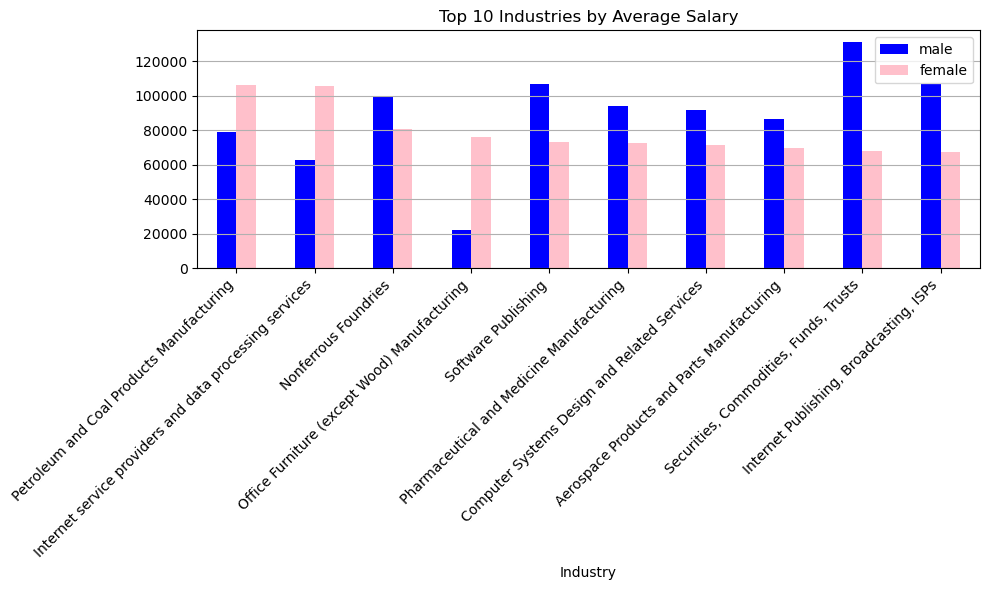

                                                    index         female  \
ind                                                                        
Petroleum and Coal Products Manufacturing             501  106250.000000   
Internet service providers and data processing ...    362  105894.400000   
Nonferrous Foundries                                  150   80894.356688   
Office Furniture (except Wood) Manufacturing          492   76135.181818   
Software Publishing                                   611   73356.338710   
Pharmaceutical and Medicine Manufacturing             391   72755.410188   
Computer Systems Design and Related Services          633   71781.144197   
Aerospace Products and Parts Manufacturing            251   69574.243590   
Securities, Commodities, Funds, Trusts                293   67937.390402   
Internet Publishing, Broadcasting, ISPs               352   67730.160000   

                                                             male  \
ind               

In [30]:
industry_mapping = {
    '7970': 'Offices of Physicians',
    '7270': 'Legal Services',
    '893': 'Office Furniture (except Wood) Manufacturing',
    '6490': 'Software Publishing',
    '2190': 'Pharmaceutical and Medicine Manufacturing',
    '7380': 'Computer Systems Design and Related Services',
    '6970': 'Securities, Commodities, Funds, Trusts',
    '3590': 'Aerospace Products and Parts Manufacturing',
    '6870': 'Banking and Related Activities',
    '3360': 'Nonferrous Foundries',
    '6672': 'Internet Publishing, Broadcasting, ISPs',
    '480': 'Petroleum and Coal Products Manufacturing',
    '6692': 'Internet service providers and data processing services',
}

# Group by industry and gender, and calculate the average salary
industry_income = (combined_df
                   .groupBy('ind', 'sex_1')
                   .agg(F.mean('incwage').alias('mean_income')))

# Pivot the DataFrame to get separate columns for Male and Female
industry_income_pivot = industry_income.groupBy('ind').pivot('sex_1').agg(F.mean('mean_income'))

# Handle missing values (if necessary)
industry_income_pivot = industry_income_pivot.fillna(0)

# Convert to Pandas DataFrame for plotting
industry_income_pd = industry_income_pivot.toPandas()

# Reset index to make 'ind' a column
industry_income_pd.reset_index(inplace=True)

# Map industry codes to descriptive names
industry_income_pd['ind'] = industry_income_pd['ind'].replace(industry_mapping)

# Calculate average salary for male and female and add a column for the difference
industry_income_pd['Income Difference'] = industry_income_pd['female'] - industry_income_pd['male']

# Sort the DataFrame by average female salary and get the top 10
top_10_industries = industry_income_pd.sort_values(by='female', ascending=False).head(10)

# Plotting the top 10 industries
top_10_industries.set_index('ind', inplace=True)  # Set 'ind' as index for better plotting
top_10_industries[['male', 'female']].plot(kind='bar', figsize=(10, 6), color=['blue', 'pink'])

# Add labels and title
plt.title('Top 10 Industries by Average Salary')
plt.xlabel('Industry')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

# Display the top 10 DataFrame
print(top_10_industries)

In [11]:
combined_df.printSchema()

root
 |-- year: string (nullable = true)
 |-- state name: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex_1: string (nullable = true)
 |-- race: string (nullable = true)
 |-- race_1: string (nullable = true)
 |-- martial status: string (nullable = true)
 |-- union type: string (nullable = true)
 |-- educ99: string (nullable = true)
 |-- occ: string (nullable = true)
 |-- ind: string (nullable = true)
 |-- wkswork1: string (nullable = true)
 |-- uhrswork: string (nullable = true)
 |-- incwage: string (nullable = true)



In [12]:
grouped_data.head()

Row(ind='467', male=23124.873646209388, female=12962.54, pay_gap=10162.333646209387)

In [13]:
combined_df.printSchema()

root
 |-- year: string (nullable = true)
 |-- state name: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex_1: string (nullable = true)
 |-- race: string (nullable = true)
 |-- race_1: string (nullable = true)
 |-- martial status: string (nullable = true)
 |-- union type: string (nullable = true)
 |-- educ99: string (nullable = true)
 |-- occ: string (nullable = true)
 |-- ind: string (nullable = true)
 |-- wkswork1: string (nullable = true)
 |-- uhrswork: string (nullable = true)
 |-- incwage: string (nullable = true)



<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- year: string (nullable = true)
 |-- state name: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex_1: string (nullable = true)
 |-- race: string (nullable = true)
 |-- race_1: string (nullable = true)
 |-- martial status: string (nullable = true)
 |-- union type: string (nullable = true)
 |-- educ99: string (nullable = true)
 |-- occ: string (nullable = true)
 |-- ind: string (nullable = true)
 |-- wkswork1: string (nullable = true)
 |-- uhrswork: string (nullable = true)
 |-- incwage: string (nullable = true)

+----+--------------------+---------+---+-----+----+------+--------------------+----------+------+---+---+--------+--------+-------+
|year|          state name| region_1|age|sex_1|race|race_1|      martial status|union type|educ99|occ|ind|wkswork1|uhrswork|incwage|
+----+--------------------+---------+---+-----+----+------+--------------------+----------+------+---+---+-

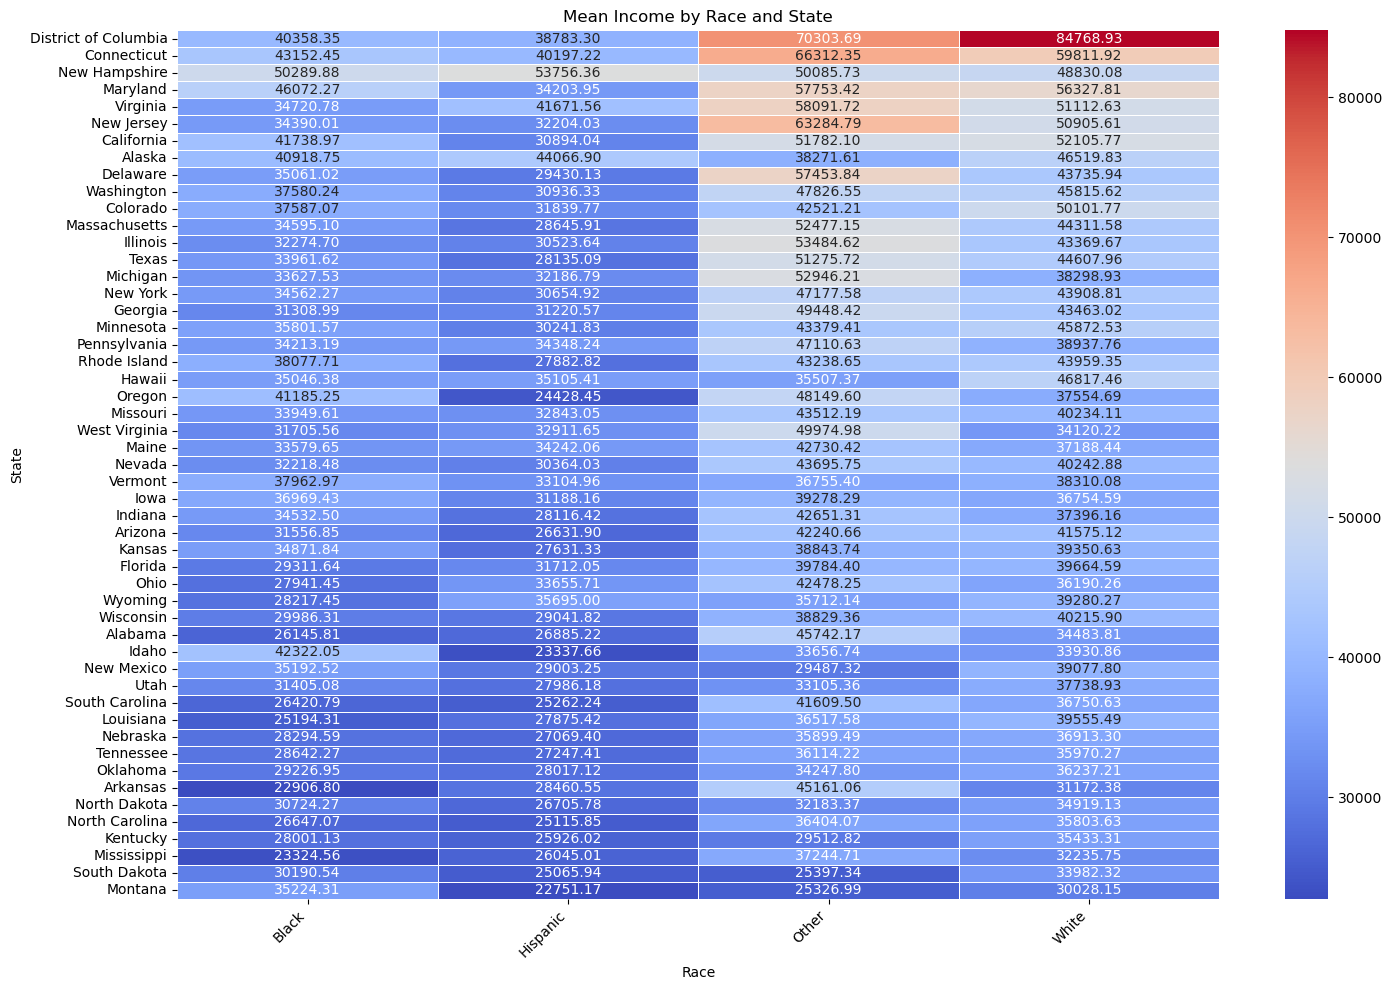

In [14]:
print(type(combined_df))

#Convert to PySpark DataFrame
if isinstance(combined_df, pd.DataFrame):
    combined_df = spark.createDataFrame(combined_df)

# Show the schema of grouped_data to check for available columns
combined_df.printSchema()
combined_df.show(5)

# Group the data to calculate mean income by state and race
mean_data = combined_df.groupBy('state name', 'race_1').agg(F.mean('incwage').alias('mean')).toPandas()

# Pivot the data to get mean income by race and state
heatmap_data = mean_data.pivot(index='state name', columns='race_1', values='mean')

# Calculate the overall mean income per state (mean across all races)
heatmap_data['Overall_Mean'] = heatmap_data.mean(axis=1)

# Sort the states by the overall mean income in descending order
heatmap_data_sorted = heatmap_data.sort_values(by='Overall_Mean', ascending=False).drop(columns='Overall_Mean')

# Create a heatmap with annotations
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_sorted, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 10})
plt.title('Mean Income by Race and State')
plt.ylabel('State')
plt.xlabel('Race')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [15]:
# Group the data by industry ('ind') and sex ('sex_1'), then calculate mean income ('incwage')
industry_income = combined_df.groupBy('ind', 'sex_1').agg(F.mean('incwage').alias('mean_incwage'))

# Pivot the DataFrame to reshape it
industry_income_pivot = industry_income.groupBy('ind').pivot('sex_1', ['male', 'female']).agg(F.first('mean_incwage'))

# Rename columns for clarity
industry_income_pivot = industry_income_pivot.withColumnRenamed('Male', 'Male').withColumnRenamed('Female', 'Female')

# Fill NaNs with median income for each group
median_male = industry_income_pivot.select(F.expr('percentile_approx(male, 0.5)').alias('median')).collect()[0]['median']
median_female = industry_income_pivot.select(F.expr('percentile_approx(female, 0.5)').alias('median')).collect()[0]['median']

industry_income_pivot = industry_income_pivot.fillna({'Male': median_male, 'Female': median_female})

# Calculate Income Difference
industry_income_pivot = industry_income_pivot.withColumn('Income Difference', industry_income_pivot['Female'] - industry_income_pivot['Male'])
industry_income_pivot = industry_income_pivot.withColumn('abs_diff', F.abs(industry_income_pivot['Income Difference']))

# Check for remaining NaN values
if industry_income_pivot.filter(F.isnan('abs_diff') | F.isnan('Income Difference')).count() > 0:
    print("NaN values found in 'abs_diff' or 'Income Difference'. Filling with 0.")
    industry_income_pivot = industry_income_pivot.fillna({'Income Difference': 0})

# Using Plotly as before
import plotly.express as px

# Create a scatter plot with Plotly
fig = px.scatter(industry_income_pivot.toPandas(), x='Male', y='Female', 
                 size='abs_diff', color='Income Difference', 
                 hover_data=['ind', 'Male', 'Female', 'Income Difference'],
                 title='Gender Pay Gap Across Industries',
                 labels={'Male': 'Average Male Income', 'Female': 'Average Female Income'},
                 color_continuous_scale='Viridis',
                 size_max=100)

# Add line for equal pay
fig.add_shape(type='line', x0=0, y0=0, x1=industry_income_pivot.select(F.max('Male')).first()[0], 
              y1=industry_income_pivot.select(F.max('Female')).first()[0], 
              line=dict(color='gray', dash='dash'))

# Show the interactive plot
fig.show()

In [16]:
# Save the interactive plot as an HTML file
fig.write_html("interactive_plot.html")


<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- year: string (nullable = true)
 |-- state name: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex_1: string (nullable = true)
 |-- race: string (nullable = true)
 |-- race_1: string (nullable = true)
 |-- martial status: string (nullable = true)
 |-- union type: string (nullable = true)
 |-- educ99: string (nullable = true)
 |-- occ: string (nullable = true)
 |-- ind: string (nullable = true)
 |-- wkswork1: string (nullable = true)
 |-- uhrswork: string (nullable = true)
 |-- incwage: string (nullable = true)

+----+--------------------+---------+---+-----+----+------+--------------------+----------+------+---+---+--------+--------+-------+
|year|          state name| region_1|age|sex_1|race|race_1|      martial status|union type|educ99|occ|ind|wkswork1|uhrswork|incwage|
+----+--------------------+---------+---+-----+----+------+--------------------+----------+------+---+---+-

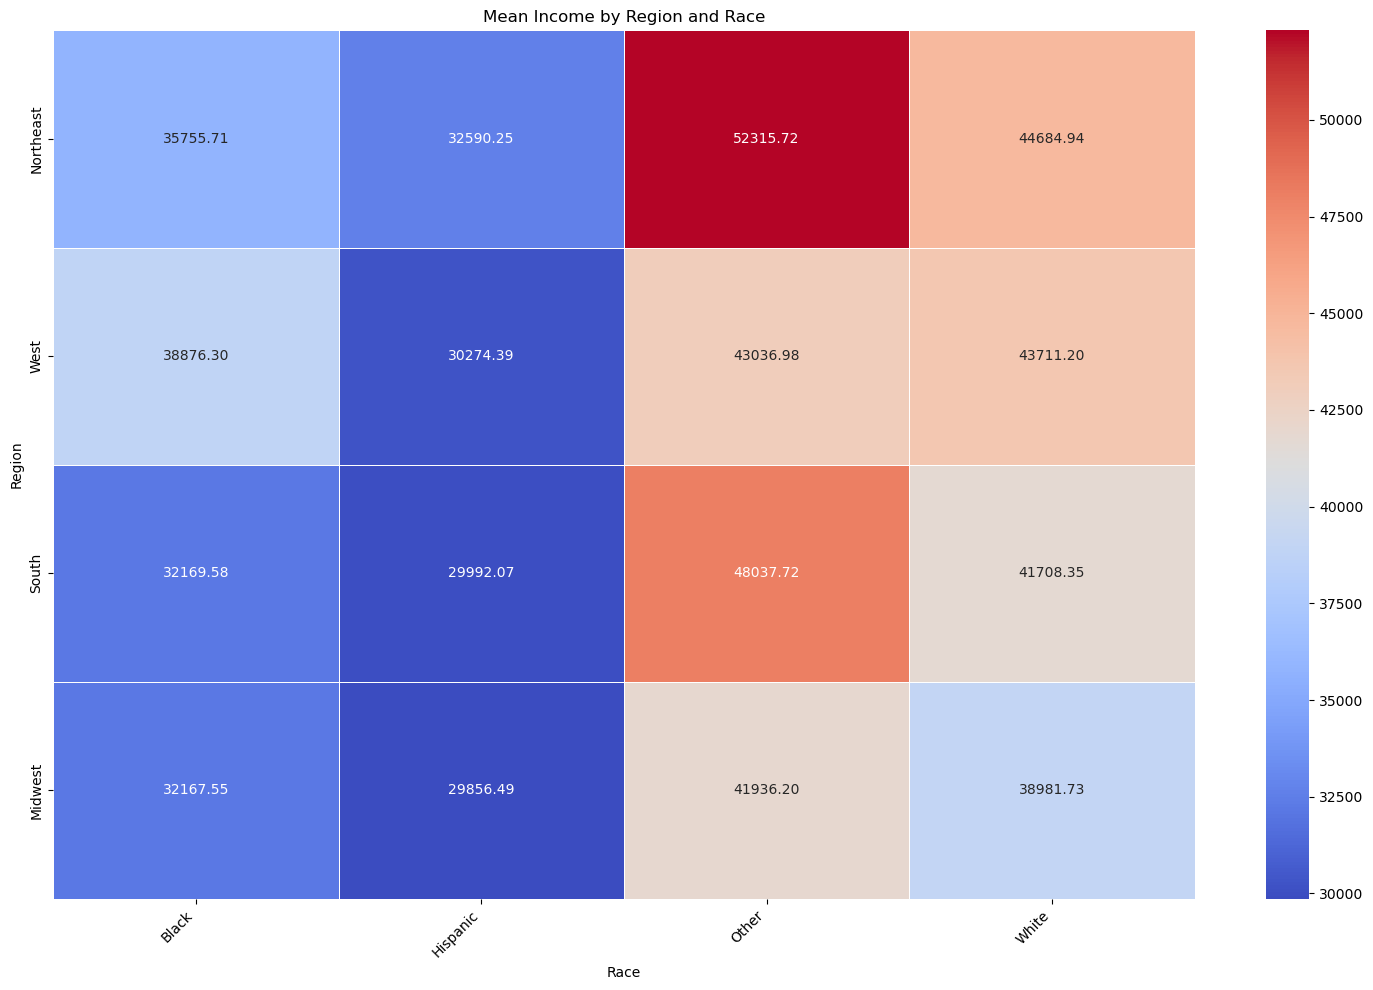

In [17]:
# Check the type of combined_df
print(type(combined_df))

# If it's a Pandas DataFrame, convert it to a PySpark DataFrame
if isinstance(combined_df, pd.DataFrame):
    combined_df = spark.createDataFrame(combined_df)

# Show the schema of the DataFrame to check available columns
combined_df.printSchema()
combined_df.show(5)

# Import necessary functions from PySpark
from pyspark.sql import functions as F

# Group the data by 'region' and 'race_1', calculate the mean income ('incwage')
grouped_data = combined_df.groupBy('region_1', 'race_1').agg(F.mean('incwage').alias('mean_incwage'))

# Convert the grouped data back to Pandas DataFrame for visualization
mean_data = grouped_data.toPandas()

# Pivot the data to get mean income by region and state
heatmap_data = mean_data.pivot(index='region_1', columns='race_1', values='mean_incwage')

# Calculate the overall mean income per state (mean across all races)
heatmap_data['Overall_Mean'] = heatmap_data.mean(axis=1)

# Sort the states by the overall mean income in descending order
heatmap_data_sorted = heatmap_data.sort_values(by='Overall_Mean', ascending=False).drop(columns='Overall_Mean')

# Import necessary libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap with annotations
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_sorted, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 10})
plt.title('Mean Income by Region and Race')
plt.ylabel('Region')
plt.xlabel('Race')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


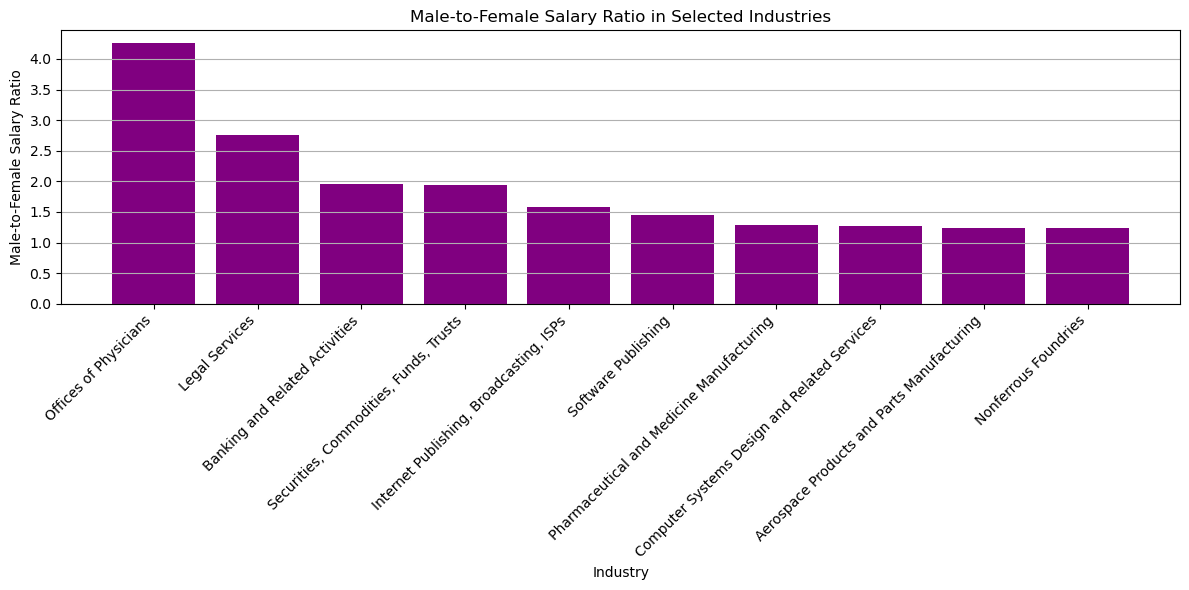

                                         ind_name  male_to_female_ratio
181                         Offices of Physicians              4.253908
505                                Legal Services              2.758037
631                Banking and Related Activities              1.959441
293        Securities, Commodities, Funds, Trusts              1.935511
352       Internet Publishing, Broadcasting, ISPs              1.578038
611                           Software Publishing              1.454098
391     Pharmaceutical and Medicine Manufacturing              1.292788
633  Computer Systems Design and Related Services              1.277992
251    Aerospace Products and Parts Manufacturing              1.242501
150                          Nonferrous Foundries              1.232819


In [37]:
# Define the mapping of industry codes to descriptive names
industry_mapping = {
    '7970': 'Offices of Physicians',
    '7270': 'Legal Services',
    '893': 'Office Furniture (except Wood) Manufacturing',
    '6490': 'Software Publishing',
    '2190': 'Pharmaceutical and Medicine Manufacturing',
    '7380': 'Computer Systems Design and Related Services',
    '6970': 'Securities, Commodities, Funds, Trusts',
    '3590': 'Aerospace Products and Parts Manufacturing',
    '6870': 'Banking and Related Activities',
    '3360': 'Nonferrous Foundries',
    '6672': 'Internet Publishing, Broadcasting, ISPs',
    '480': 'Petroleum and Coal Products Manufacturing'
}

# Group by industry and gender, and calculate the average salary
industry_income = (combined_df
                   .groupBy('ind', 'sex_1')
                   .agg(F.mean('incwage').alias('mean_income')))

# Pivot the DataFrame to get separate columns for Male and Female
industry_income_pivot = industry_income.groupBy('ind').pivot('sex_1').agg(F.mean('mean_income'))

# Handle missing values (if necessary)
industry_income_pivot = industry_income_pivot.fillna(0)

# Create a new column for industry names based on mapping
industry_income_pivot = industry_income_pivot.withColumn('ind_name', 
    F.when(F.col('ind') == '7970', 'Offices of Physicians')
    .when(F.col('ind') == '7270', 'Legal Services')
    .when(F.col('ind') == '893', 'Office Furniture (except Wood) Manufacturing')
    .when(F.col('ind') == '6490', 'Software Publishing')
    .when(F.col('ind') == '2190', 'Pharmaceutical and Medicine Manufacturing')
    .when(F.col('ind') == '7380', 'Computer Systems Design and Related Services')
    .when(F.col('ind') == '6970', 'Securities, Commodities, Funds, Trusts')
    .when(F.col('ind') == '3590', 'Aerospace Products and Parts Manufacturing')
    .when(F.col('ind') == '6870', 'Banking and Related Activities')
    .when(F.col('ind') == '3360', 'Nonferrous Foundries')
    .when(F.col('ind') == '6672', 'Internet Publishing, Broadcasting, ISPs')
    .when(F.col('ind') == '480', 'Petroleum and Coal Products Manufacturing')
    .otherwise(F.col('ind')))

# Calculate the male-to-female salary ratio
industry_income_pivot = industry_income_pivot.withColumn('male_to_female_ratio',
    F.when(F.col('female') > 0, F.col('male') / F.col('female'))
    .otherwise(0)
)

# Convert to Pandas DataFrame for better visualization
industry_income_pd = industry_income_pivot.toPandas()

# Select only industries of interest
industries_of_interest = list(industry_mapping.keys())
industry_income_filtered = industry_income_pd[industry_income_pd['ind'].isin(industries_of_interest)]

# Sort the DataFrame by male-to-female ratio and get the top 10
top_10_industries = industry_income_filtered.sort_values(by='male_to_female_ratio', ascending=False).head(10)

# Plotting the top industries' male-to-female salary ratios
plt.figure(figsize=(12, 6))
plt.bar(top_10_industries['ind_name'], top_10_industries['male_to_female_ratio'], color='purple')

# Add labels and title
plt.title('Male-to-Female Salary Ratio in Selected Industries')
plt.xlabel('Industry')
plt.ylabel('Male-to-Female Salary Ratio')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

# Display the top 10 DataFrame
print(top_10_industries[['ind_name', 'male_to_female_ratio']])

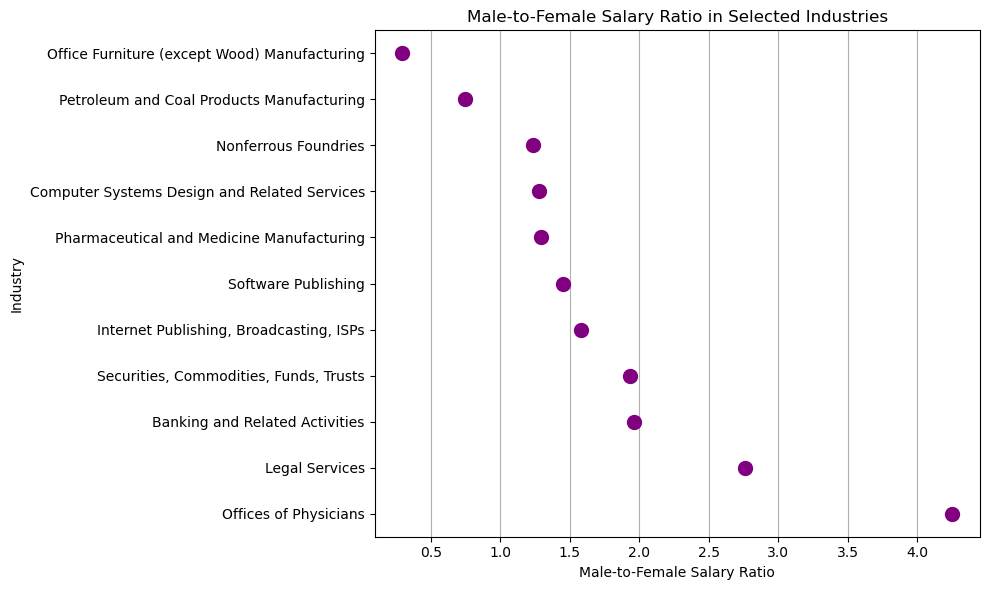

                                         ind_name  male_to_female_ratio
181                         Offices of Physicians              4.253908
505                                Legal Services              2.758037
631                Banking and Related Activities              1.959441
293        Securities, Commodities, Funds, Trusts              1.935511
352       Internet Publishing, Broadcasting, ISPs              1.578038
611                           Software Publishing              1.454098
391     Pharmaceutical and Medicine Manufacturing              1.292788
633  Computer Systems Design and Related Services              1.277992
150                          Nonferrous Foundries              1.232819
501     Petroleum and Coal Products Manufacturing              0.743624
492  Office Furniture (except Wood) Manufacturing              0.293436


In [43]:
# Calculate the male-to-female salary ratio
industry_income_pivot = industry_income_pivot.withColumn(
    'male_to_female_ratio',
    F.when(F.col('female') > 0, F.col('male') / F.col('female'))
    .otherwise(0)
)

# Convert to Pandas DataFrame for plotting
industry_income_pd = industry_income_pivot.toPandas()

# Define the industry names mapping
industry_mapping = {
    '7970': 'Offices of Physicians',
    '7270': 'Legal Services',
    '893': 'Office Furniture (except Wood) Manufacturing',
    '6490': 'Software Publishing',
    '2190': 'Pharmaceutical and Medicine Manufacturing',
    '7380': 'Computer Systems Design and Related Services',
    '6970': 'Securities, Commodities, Funds, Trusts',
    '3590': 'Aerospace Products and Parts Manufacturing',
    '6870': 'Banking and Related Activities',
    '3360': 'Nonferrous Foundries',
    '6672': 'Internet Publishing, Broadcasting, ISPs',
    '480': 'Petroleum and Coal Products Manufacturing'
}

# Map industry codes to names
industry_income_pd['ind_name'] = industry_income_pd['ind'].replace(industry_mapping)

# List of industries to display
selected_industries = [
    'Offices of Physicians', 
    'Legal Services', 
    'Office Furniture (except Wood) Manufacturing', 
    'Software Publishing', 
    'Pharmaceutical and Medicine Manufacturing', 
    'Computer Systems Design and Related Services', 
    'Securities, Commodities, Funds, Trusts', 
    'Banking and Related Activities', 
    'Nonferrous Foundries', 
    'Internet Publishing, Broadcasting, ISPs', 
    'Petroleum and Coal Products Manufacturing'
]

# Filter the DataFrame for only the selected industries
filtered_industries = industry_income_pd[industry_income_pd['ind_name'].isin(selected_industries)]

# Sort the filtered DataFrame by the male_to_female_ratio
filtered_industries = filtered_industries.sort_values(by='male_to_female_ratio', ascending=False)

# Create a dot plot
plt.figure(figsize=(10, 6))
plt.plot(filtered_industries['male_to_female_ratio'], filtered_industries['ind_name'], 'o', color='purple', markersize=10)

# Add labels and title
plt.title('Male-to-Female Salary Ratio in Selected Industries')
plt.xlabel('Male-to-Female Salary Ratio')
plt.ylabel('Industry')
plt.grid(axis='x')

# Show the plot
plt.tight_layout()
plt.show()

# Display the filtered DataFrame
print(filtered_industries[['ind_name', 'male_to_female_ratio']])